In [1]:
import pandas as pd
import os
import numpy as np
import h5py
import torch

#### Global variables

In [2]:
SEED = 12345
#Hyperparameters
num_epochs_global = 33
batch_size_global = 32
num_neurons_1hl = 14
num_neurons_2hl = 10



#Plotting
font_size = 16
header_font_size = 20

# Data Preprocessing

In [3]:
mat_file = "original_data/ReadBrownDwarf.mat"
data_path = "original_data/"
idTE = np.load(data_path + "idTE.npy")
idTR = np.load(data_path + "idTR.npy")
labelTE = np.load(data_path + "labelTE.npy")
labelTR = np.load(data_path + "labelTR.npy")

In [4]:
#Extracting the data from the mat file
with h5py.File(mat_file, 'r') as f:
    data = f["data"]
    data = pd.DataFrame(data).T
data = data.drop(columns=[0,1,3,5,7,9,11,16,17,18,19,23,24,25])
data

,2,4,6,8,10,12,13,14,15,20,21,22
0,5.5560,5.7600,5.9470,6.0720,6.1710,5.539,5.374,5.530,5.435,5.562,5.539,5.479
1,0.0000,7.6116,0.0000,7.5167,13.5874,6.880,6.919,6.946,6.484,6.896,6.921,6.932
2,10.5120,10.6920,10.8660,10.9890,11.0450,10.360,10.387,10.402,8.625,10.408,10.400,10.378
3,0.0000,0.0000,6.8603,0.0000,5.8626,5.691,5.619,5.752,5.688,5.671,5.717,5.704
4,0.0000,0.0000,6.3206,5.9504,5.4329,5.405,5.225,5.429,5.389,5.430,5.402,5.333
...,...,...,...,...,...,...,...,...,...,...,...,...
5664,9.1227,9.1823,0.0000,9.0066,8.8481,8.372,8.400,8.398,8.002,8.358,8.389,8.398
5665,0.0000,9.5538,0.0000,10.7253,11.3126,8.760,8.793,8.777,8.133,8.778,8.804,8.766
5666,0.0000,9.8405,9.2025,10.1089,10.0227,9.177,9.201,9.204,8.834,9.180,9.187,9.180
5667,10.4915,10.2538,10.0057,10.4418,10.4596,9.561,9.592,9.581,8.685,9.693,9.678,9.622


Data imputation



Instead of replacing zero-entries with the mean of the column, we train a linear regression model on the rows with complete data and make the model predict on our missing values.

In [5]:
from sklearn.linear_model import LinearRegression
np.random.seed(SEED)
columns_with_zero = data.columns[(data == 0).any()].tolist()

print(columns_with_zero)
target_columns = columns_with_zero

for target_column in target_columns:
    df_zeros = data[data[target_column] == 0]
    df_no_zeros = data[data[target_column] != 0]

    X_train = df_no_zeros.drop(columns=target_column)
    y_train = df_no_zeros[target_column]

    X_test = df_zeros.drop(columns=target_column)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_test = model.predict(X_test)

    # Replace the zero values in the original dataframe
    data.loc[data[target_column] == 0, target_column] = y_test

data

[2, 4, 6, 8, 10, 12, 13, 14, 15, 20, 21, 22]


,2,4,6,8,10,12,13,14,15,20,21,22
0,5.556000,5.760000,5.947000,6.07200,6.1710,5.539,5.374,5.530,5.435,5.562,5.539,5.479
1,7.188024,7.611600,10.325725,7.51670,13.5874,6.880,6.919,6.946,6.484,6.896,6.921,6.932
2,10.512000,10.692000,10.866000,10.98900,11.0450,10.360,10.387,10.402,8.625,10.408,10.400,10.378
3,4.558292,4.395859,6.860300,7.38605,5.8626,5.691,5.619,5.752,5.688,5.671,5.717,5.704
4,4.568653,4.675897,6.320600,5.95040,5.4329,5.405,5.225,5.429,5.389,5.430,5.402,5.333
...,...,...,...,...,...,...,...,...,...,...,...,...
5664,9.122700,9.182300,9.393351,9.00660,8.8481,8.372,8.400,8.398,8.002,8.358,8.389,8.398
5665,9.322651,9.553800,11.050478,10.72530,11.3126,8.760,8.793,8.777,8.133,8.778,8.804,8.766
5666,10.257572,9.840500,9.202500,10.10890,10.0227,9.177,9.201,9.204,8.834,9.180,9.187,9.180
5667,10.491500,10.253800,10.005700,10.44180,10.4596,9.561,9.592,9.581,8.685,9.693,9.678,9.622


Since we have imputed the missing values using a ML model we want to scale the data as we do not know what the variance of our predictions.

Splitting into training and test data before scaling it

In [6]:
from sklearn.preprocessing import StandardScaler

#Splitting in training and test data
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []
for i in range(len(idTR)):
    X_train_list.append(data.iloc[idTR[i] - 1]) #idTR is 1 indexed
    X_test_list.append(data.iloc[idTE[i] - 1])  #idTE is 1 indexed
    y_train_list.append(labelTR[i])
    y_test_list.append(labelTE[i])
    #Scaling
    scaler = StandardScaler()
    X_train_list[i] = scaler.fit_transform(X_train_list[i])
    X_test_list[i] = scaler.transform(X_test_list[i])

X_train_arr = np.array(X_train_list)
X_test_arr = np.array(X_test_list)
y_train_arr = np.array(y_train_list)
y_test_arr = np.array(y_test_list)

In [7]:
X_train_arr.shape, X_test_arr.shape, y_train_arr.shape, y_test_arr.shape

((5, 4535, 12), (5, 1134, 12), (5, 4535), (5, 1134))

# NN

Network structure: $26$ x $14$ x $10$ x $1$

In [21]:
torch.manual_seed(SEED) # Added seed for reproducibility for all the activation functions

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader



# Convert numpy arrays or pandas DataFrames to PyTorch tensors if needed
X_train_tens = torch.tensor(X_train_arr, dtype=torch.float32)
y_train_tens = torch.tensor(y_train_arr, dtype=torch.long)

# Defining a simple neural network class for binary classification
class NeuralNet(nn.Module):
    def __init__(self, input_size, activation=nn.ReLU()):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, num_neurons_1hl)
        self.activation = activation
        self.fc2 = nn.Linear(num_neurons_1hl, num_neurons_2hl)
        self.fc3 = nn.Linear(num_neurons_2hl, 1)# Output layer with single neuron (binary classification)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Apply sigmoid activation for binary classification of final output
        return x


## Training Loop

In [23]:
from sklearn.model_selection import train_test_split


losses_fold = []


val_losses = []  # Store validation losses
all_losses = []  # Store training losses for all folds
all_val_losses = []  # Store validation losses for all folds
all_minimas = [] #Store lowest validation losses for all folds

for i in range(len(X_train_tens)):
    # Initializing
    input_size = X_train_tens[i].shape[1]
    model = NeuralNet(input_size)


    # Define loss function and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters())

    # Prepare data for training using DataLoader
    batch_size = batch_size_global
    X_train, X_val, y_train, y_val = train_test_split(X_train_tens[i], y_train_tens[i], test_size=0.2)  # Split data into training and validation sets

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)  # Create validation dataset

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # Create validation DataLoader

    # Training loop
    # Training loop
    temp_loss = []
    num_epochs = num_epochs_global
    losses = []  # Store training losses for this fold
    val_losses = []  # Store validation losses for this fold
    minima_index = 0
    minima = 1
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            outputs = outputs.squeeze(dim=1)  # Remove extra dimension for binary classification
            loss = criterion(outputs, labels.float())  # Calculate loss

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average loss per epoch
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
        temp_loss.append(running_loss / len(train_loader))
    
        # Calculate validation loss
        val_loss = 0.0
        model.eval()  # Switch to evaluation mode
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                outputs = outputs.squeeze(dim=1)
                loss = criterion(outputs, labels.float())
                val_loss += loss.item()

        model.train()  # Switch back to training mode

        # Store losses
        losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        if val_loss < minima:
            minima_index = epoch
            minima = val_loss

        # Print average loss per epoch
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}")
    losses_fold.append(temp_loss)
    all_losses.append(losses)
    all_val_losses.append(val_losses)
    all_minimas.append(minima_index)

    model.eval()  # Switch to evaluation mode
    with torch.no_grad():
        predictions = model(X_train_tens[i])
        predictions = (predictions > 0.5).int()  # Convert probabilities to binary predictions (0 or 1)


    dir_path = './models/'
    # Check if the directory exists
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    #Saving model for later use
    model_dir = './models/'
    os.makedirs(model_dir, exist_ok=True)  # Create directory if it doesn't exist
    model_path = os.path.join(model_dir, f'fold{i}_binary_classification_model.pth')
    torch.save(model.state_dict(), model_path)


    # Calculate mean losses
mean_losses = np.array([sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*all_losses)])
mean_val_losses = np.array([sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*all_val_losses)])
print(mean_losses)
print(mean_val_losses)
for epoch in range(num_epochs_global):
    print(f"Epoch {epoch+1}, Mean Training Loss: {mean_losses[epoch]}, Mean Validation Loss: {mean_val_losses[epoch]}")

Epoch 1, Loss: 0.5718018867467579
Epoch 1, Loss: 0.5718018867467579, Validation Loss: 0.41818478292432326
Epoch 2, Loss: 0.34684432141090693
Epoch 2, Loss: 0.34684432141090693, Validation Loss: 0.2632134089182163
Epoch 3, Loss: 0.21033455470674917
Epoch 3, Loss: 0.21033455470674917, Validation Loss: 0.16219439229060864
Epoch 4, Loss: 0.12868357626231094
Epoch 4, Loss: 0.12868357626231094, Validation Loss: 0.11798944093030074
Epoch 5, Loss: 0.09650908122982896
Epoch 5, Loss: 0.09650908122982896, Validation Loss: 0.10041499446178305
Epoch 6, Loss: 0.0811670162273865
Epoch 6, Loss: 0.0811670162273865, Validation Loss: 0.08986496437212517
Epoch 7, Loss: 0.06962271517534789
Epoch 7, Loss: 0.06962271517534789, Validation Loss: 0.07950684001091225
Epoch 8, Loss: 0.06013354103554759
Epoch 8, Loss: 0.06013354103554759, Validation Loss: 0.07215330830036566
Epoch 9, Loss: 0.05372109735515295
Epoch 9, Loss: 0.05372109735515295, Validation Loss: 0.0664820990300384
Epoch 10, Loss: 0.0515190189451044

In [24]:
losses_fold = np.array(losses_fold)
losses_fold.shape

(5, 33)

In [25]:
mean_losses.shape, mean_val_losses.shape

((33,), (33,))

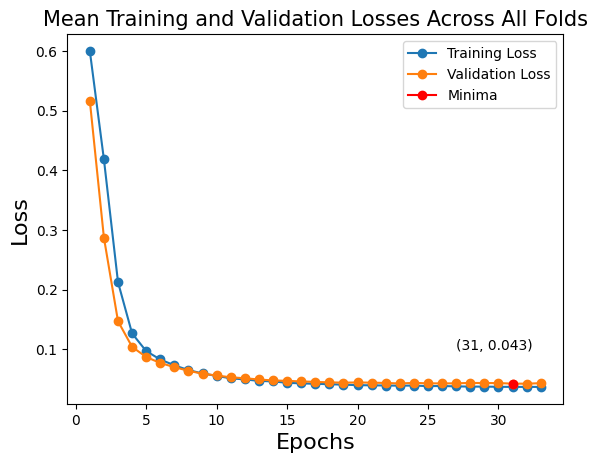

In [26]:
import matplotlib.pyplot as plt

# Calculate mean losses
#mean_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*all_losses)]
#mean_val_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*all_val_losses)]
minima = np.min(mean_val_losses)
minima_index = np.argmin(mean_val_losses)

plt.plot(range(1, num_epochs+1), mean_losses, "-o", label='Training Loss')
plt.plot(range(1, num_epochs+1), mean_val_losses, "-o", label='Validation Loss')
plt.plot(minima_index, minima, "-o", color = "r", label = "Minima")

plt.annotate(f"({minima_index}, {format(minima, '.3f')})", (minima_index-4, 0.1))
plt.title('Mean Training and Validation Losses Across All Folds', fontsize = header_font_size-5)
plt.xlabel('Epochs', fontsize = font_size)
plt.ylabel('Loss', fontsize = font_size )
plt.legend()

plt.show()

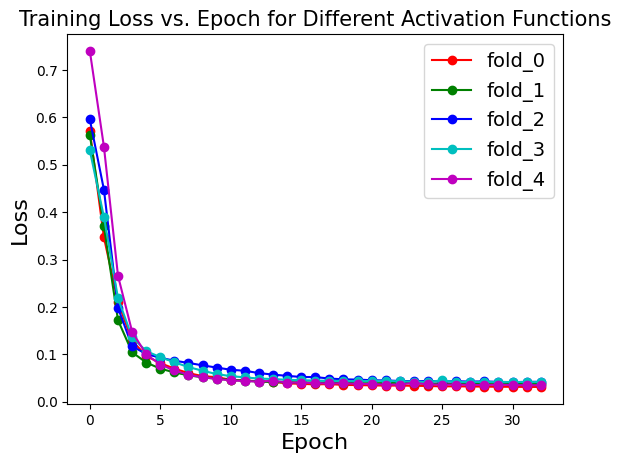

In [27]:
import matplotlib.pyplot as plt

fold_colors = ['r', 'g', 'b', 'c', 'm']
for i, loss in enumerate(losses_fold):
    plt.plot(loss, "-o", label=f"fold_{i}", color=fold_colors[i % len(fold_colors)])
plt.legend(fontsize = font_size - 2)
plt.xlabel("Epoch", size = font_size)
plt.ylabel("Loss", size = font_size)
plt.title("Training Loss vs. Epoch for Different Activation Functions", size = header_font_size - 5)
plt.show()

Predicting on training data

In [28]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, confusion_matrix

mcc_scores = []
for i in range(len(X_train_tens)):
    print(f"Evaluating model on fold: {i}")
    # Load the trained model
    input_size = input_size 
    model = NeuralNet(input_size)
    model.load_state_dict(torch.load(f'models/fold{i}_binary_classification_model.pth'))  # Load the trained model state (MACos)

    X_train = X_train_tens[i].float()
    y_train = y_train_tens[i].float()

    # Prepare test dataset and dataloader
    batch_size = batch_size_global
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle for testing

    model.eval()  # Switch to evaluation mode
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate Matthews Correlation Coefficient (MCC)
    mcc_tr = matthews_corrcoef(y_true, y_pred)
    mcc_scores.append(mcc_tr)

    print(f"Training: MCC-score: {mcc_tr}, check against the test set for overfitting")

print(f"Mean MCC score on training set: {np.mean(mcc_scores)}")

Evaluating model on fold: 0
Training: MCC-score: 0.9729248377781957, check against the test set for overfitting
Evaluating model on fold: 1
Training: MCC-score: 0.9723615774139069, check against the test set for overfitting
Evaluating model on fold: 2
Training: MCC-score: 0.9746115638731802, check against the test set for overfitting
Evaluating model on fold: 3
Training: MCC-score: 0.9708893688906745, check against the test set for overfitting
Evaluating model on fold: 4
Training: MCC-score: 0.9738773112889413, check against the test set for overfitting
Mean MCC score on training set: 0.9729329318489798


## Testing the model on the test set

In [29]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, confusion_matrix

mcc_scores = []
all_metrics = {}
all_confusion_matrices = {}
for i in range(len(X_train_tens)):
    print(f"Evaluating model on fold: {i}")
    # Load the trained model
    input_size = input_size  
    model = NeuralNet(input_size)
    model.load_state_dict(torch.load(f'models/fold{i}_binary_classification_model.pth'))  # Load the trained model state (MACos)


    X_test = torch.tensor(X_test_arr[i], dtype=torch.float32)
    y_test = torch.tensor(y_test_arr[i], dtype=torch.float32)

    # Prepare test dataset and dataloader
    batch_size = batch_size_global
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle for testing

    model.eval()  # Switch to evaluation mode
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculating different scoring methods
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred) # Calculate Matthews Correlation Coefficient (MCC)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary') 
    recall = recall_score(y_true, y_pred, average='binary')   
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[1,0])

    # Store the metrics in a dictionary for easy plotting
    metrics = {'F1 Score': f1, 'MCC': mcc, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall}
    
    all_metrics[f"fold_{i}"] = metrics
    all_confusion_matrices[f"fold_{i}"] = conf_matrix

    
    print(f"Testing MCC score: {metrics['MCC']}")
    mcc_scores.append(metrics['MCC'])

print(f"Mean MCC on TEST SET: {np.mean(mcc_scores)}")

Evaluating model on fold: 0
Testing MCC score: 0.9718031173631969
Evaluating model on fold: 1
Testing MCC score: 0.9738292593803489
Evaluating model on fold: 2
Testing MCC score: 0.9741089135128148
Evaluating model on fold: 3
Testing MCC score: 0.9825859950859951
Evaluating model on fold: 4
Testing MCC score: 0.9546147643325661
Mean MCC on TEST SET: 0.9713884099349844


It is expected that 𝑧𝑃𝑆1 −𝐽 is the most important feature as Burningham et al. (2013), which we used as a baseline, is nearly entirely based on the above colour. However, it only plays a secondary role in most of the models. Unlike the
previous works, we revealed the importance of the (𝑖−𝑦)𝑃 𝑆1 colour index. It is the most important feature in most cases and the colour selection (𝑖 − 𝑦)𝑃𝑆1 > 1.88 alone gives an MCC score of 0.968 on the testing data.

(0.8, 1.0)

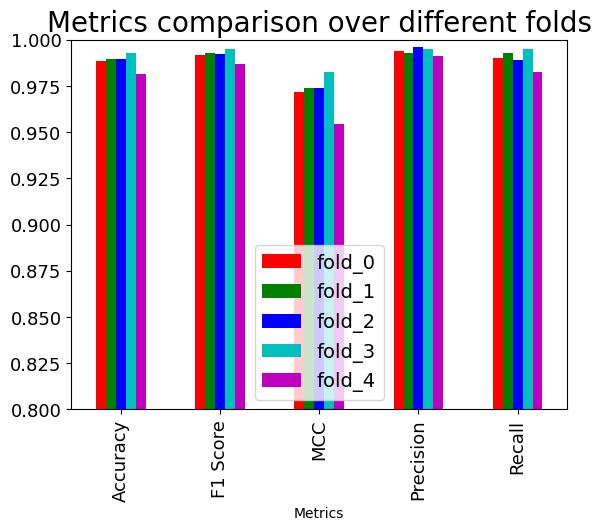

In [30]:
data = pd.DataFrame(all_metrics)
data = data.reset_index().rename(columns={'index': 'Metrics'})


data = pd.melt(data, id_vars='Metrics', var_name='Fold', value_name='Value')

data = data.set_index(['Metrics', 'Fold']).Value
data.unstack().plot(kind='bar', stacked=False, color = fold_colors, fontsize = font_size-3)
plt.legend(fontsize = font_size-2)
plt.title("Metrics comparison over different folds", size = header_font_size)
plt.ylim(0.8,1)

[0.9891240446796002, 0.992413254357896, 0.9732470967521203, 0.9942533124697489, 0.9905845053084317]
['Accuracy', 'F1 Score', 'MCC', 'Precision', 'Recall']


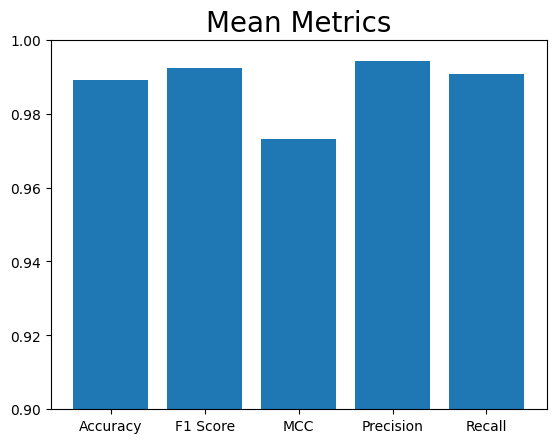

In [31]:
#Removing the 3rd and 4th quartile since they are deviating a lot from the mean
mean_Accuracy = np.mean(data['Accuracy'][:3])
mean_F1_score = np.mean(data['F1 Score'][:3])
mean_MCC      = np.mean(data['MCC'][:3])
mean_Precision= np.mean(data['Precision'][:3])
mean_Recall   = np.mean(data['Recall'][:3])

Mean_metrics = [mean_Accuracy, mean_F1_score, mean_MCC, mean_Precision, mean_Recall]
names = ["Accuracy", "F1 Score", "MCC", "Precision", "Recall"]

# Mean_metrics.unstack().plot(kind='bar', stacked=False, color = fold_colors, fontsize = font_size-3)
plt.bar(names, Mean_metrics)
plt.title("Mean Metrics", size = header_font_size)
plt.ylim(0.9,1)

print(Mean_metrics)
print(names)

## Confusion matrix comparison

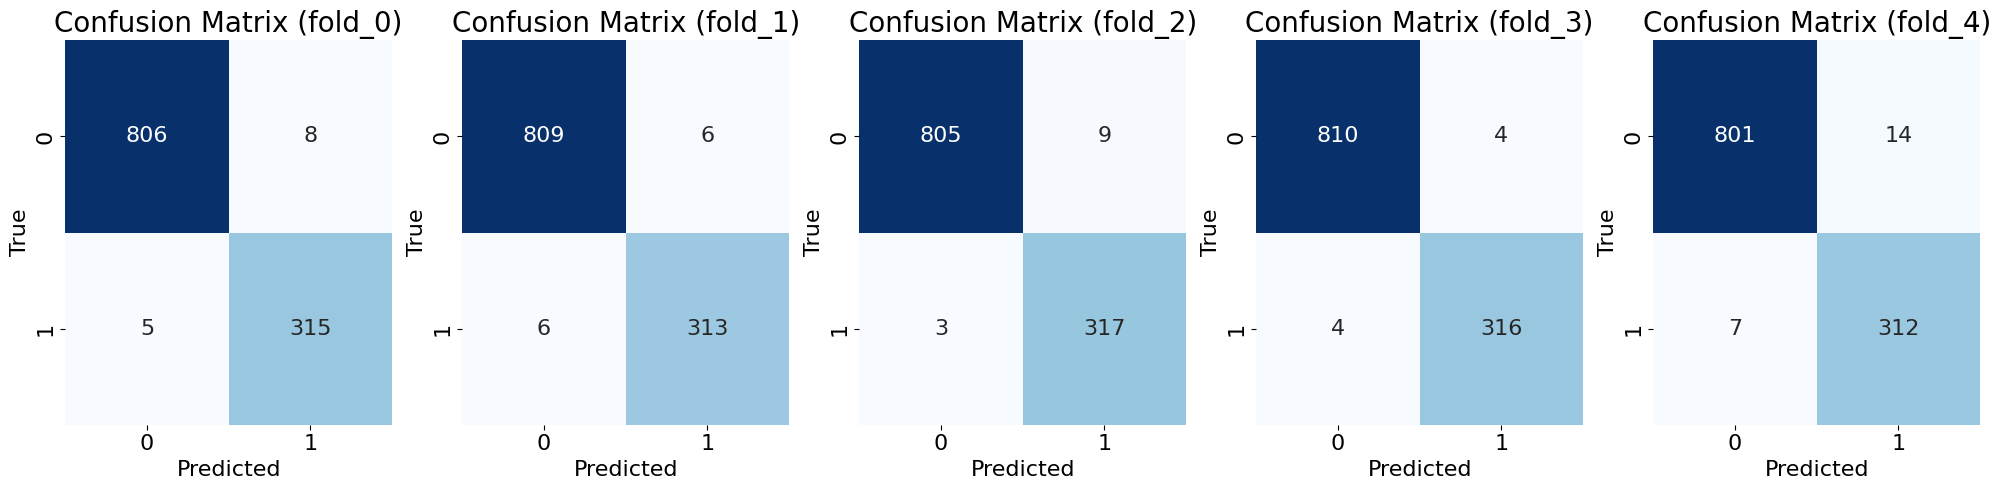

In [32]:
import seaborn as sns

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i in range(len(X_train_tens)):
    conf_matrix = all_confusion_matrices[f"fold_{i}"]

    # Create a heatmap for the confusion matrix for the i-th fold
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar = False, annot_kws={"size": font_size})

    axes[i].set_title(f'Confusion Matrix (fold_{i})', size = header_font_size)
    axes[i].set_xlabel('Predicted', size = font_size)
    axes[i].set_ylabel('True', size = font_size)
    axes[i].tick_params(axis='both', which='major', labelsize=font_size)

plt.tight_layout()
plt.show()

fold_0
fold_1
fold_2
fold_3
fold_4


{'fold_0': array([[806,   8],
        [  5, 315]]),
 'fold_1': array([[809,   6],
        [  6, 313]]),
 'fold_2': array([[805,   9],
        [  3, 317]]),
 'fold_3': array([[810,   4],
        [  4, 316]]),
 'fold_4': array([[801,  14],
        [  7, 312]])}

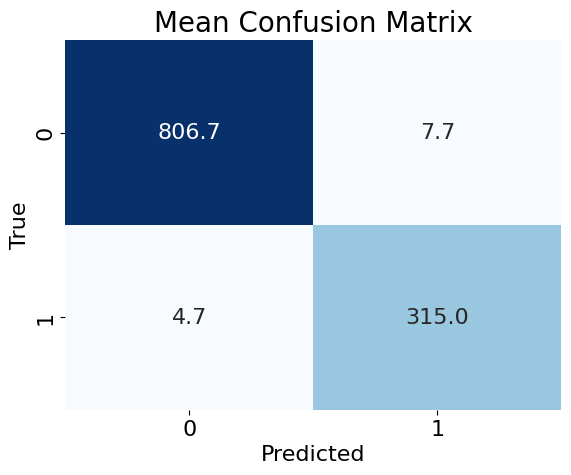

In [33]:

temp_conf_matrix = np.zeros((2,2))

for fold, conf_values in all_confusion_matrices.items():
    print(fold)
    if (fold != "fold_3" and fold !="fold_4"):
        for i in range(len(conf_values)):
            for j in range(len(conf_values[i])):
                temp_conf_matrix[i][j] += conf_values[i][j]
average_conf_matrix = temp_conf_matrix/3


sns.heatmap(average_conf_matrix, annot=True, fmt='.1f', cmap='Blues', cbar = False, annot_kws={"size": font_size})

plt.title(f'Mean Confusion Matrix', size = header_font_size)
plt.xlabel('Predicted', size = font_size)
plt.ylabel('True', size = font_size)
plt.tick_params(axis='both', which='major', labelsize=font_size)
all_confusion_matrices